# RandomGraph -- Distortion

This is a formal experiment on testing the performance of FastMap when approximate the target distance on directed graph.

**Test DataSet:**

1. Simulated random directed graphs (10 random, and get average)
2. State lattice of game map
3. Roadmap, directed

The embedding dimention $K$ is a hyperparameter, and incurs a hiden process of finding the relation between distortion and $K$, and choose the best one for external comparison with other benchmark algorithms.

**Test design:**

1. Test the distortion of embedding `average`
2. Test the distortion of embedding `max`
3. Test the distortion of `min` through embedding `average` and `max`
4. Test the distortion of purely using of differential heuristic
5. Test the distortion of real distances through embedding `average` and `max`, plus the stored true distances.

**Test Goal:**

The accuracy of heuristic value by FastMap.

In [1]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max, difastmap_average_limitstorage, difastmap_max_limitstorage 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

Density: 0.006961961961961962


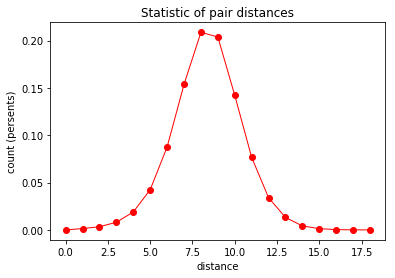

In [2]:
n = 1000
p = 0.007
low = 1
high = 5

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

In [3]:
utils.connectivity_info(G)
countn = G.number_of_nodes()
counte = G.number_of_edges()
density = float(counte)/(countn * (countn-1))
print(countn)
print(counte)
print(density)

A strongly connected graph.
1000
6955
0.006961961961961962


In [4]:
def get_dijkstra_path_length(G):
    dijkstra_path_length = {}
    for node in G.nodes:
        dijkstra_path_length[node] = nx.single_source_dijkstra_path_length(G, node)
    return dijkstra_path_length

In [5]:
dijkstra_path_length = get_dijkstra_path_length(G)

## Test the distortion of embedding average

In [6]:
def meta_distortion_analyse(i):
    global G, embedding, subset, alg, variant, threshold
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        if embdis > target_dis + threshold:
            larger += 1
        elif embdis < target_dis - threshold:
            smaller += 1
        else:
            equal += 1
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d, larger, equal, smaller]

def distortion_analyse_mp(G, embedding, subset, alg, variant, threshold):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_analyse, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d, larger, equal, smaller = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base

    return float(sigma)/ave_d, larger, equal, smaller

In [14]:
klist = [19, 20, 21, 22, 23, 24, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:19
Pool size: 8
(0.23217607860771997, 109670.0, 125860.0, 403670.0)
#########Test for K:20
Pool size: 8
(0.2107034075464472, 138772.0, 142902.0, 357526.0)
#########Test for K:21
Pool size: 8
(0.20885749900962458, 145908.0, 143310.0, 349982.0)
#########Test for K:22
Pool size: 8
(0.1962173405948348, 181792.0, 153904.0, 303504.0)
#########Test for K:23
Pool size: 8
(0.19760304710983495, 239394.0, 153908.0, 245898.0)
#########Test for K:24
Pool size: 8
(0.19567454020977573, 259226.0, 157100.0, 222874.0)
#########Test for K:25
Pool size: 8
(0.1989072467652666, 286324.0, 156244.0, 196632.0)


In [17]:
klist = [6, 7, 8, 9, 10, 11]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:6
Pool size: 8
(0.44970623037969537, 29778.0, 52578.0, 556844.0)
#########Test for K:7
Pool size: 8
(0.37748176317184295, 71078.0, 81772.0, 486350.0)
#########Test for K:8
Pool size: 8
(0.32423486400424995, 145834.0, 109302.0, 384064.0)
#########Test for K:9
Pool size: 8
(0.3105264612578978, 240254.0, 119924.0, 279022.0)
#########Test for K:10
Pool size: 8
(0.36321090877599194, 352586.0, 107702.0, 178912.0)
#########Test for K:11
Pool size: 8
(0.45783672247296575, 442642.0, 85972.0, 110586.0)


## Test the distortion of embedding max

In [18]:
klist = [19, 20, 21, 22, 23, 24, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:19
Pool size: 8
(0.21640271040770756, 219184.0, 125982.0, 294034.0)
#########Test for K:20
Pool size: 8
(0.22047227590421875, 249144.0, 124722.0, 265334.0)
#########Test for K:21
Pool size: 8
(0.2307642437847856, 333842.0, 121766.0, 183592.0)
#########Test for K:22
Pool size: 8
(0.2274567971560161, 339214.0, 122964.0, 177022.0)
#########Test for K:23
Pool size: 8
(0.2638377054080454, 396264.0, 109016.0, 133920.0)
#########Test for K:24
Pool size: 8
(0.2773800155432197, 425916.0, 99918.0, 113366.0)
#########Test for K:25
Pool size: 8
(0.2856713048579809, 444460.0, 97640.0, 97100.0)


In [19]:
klist = [6, 7, 8, 9, 10, 11]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:6
Pool size: 8
(0.3865966648424322, 86158.0, 86938.0, 466104.0)
#########Test for K:7
Pool size: 8
(0.34477790259607555, 120678.0, 104782.0, 413740.0)
#########Test for K:8
Pool size: 8
(0.320808081578268, 225942.0, 122388.0, 290870.0)
#########Test for K:9
Pool size: 8
(0.38385722802393, 324264.0, 112800.0, 202136.0)
#########Test for K:10
Pool size: 8
(0.41428628096960607, 396906.0, 103956.0, 138338.0)
#########Test for K:11
Pool size: 8
(0.47253127774627957, 467894.0, 84900.0, 86406.0)


## Test the distortion of embedding min

In [7]:
def meta_distortion_min(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        distance_reverse = dijkstra_path_length[node_2][node_1]
        target_dis = min(float(distance), float(distance_reverse))
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        embdis = 2.0*embdis_aver - embdis_max
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_min_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_min, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [21]:
klist = [18, 19, 20, 21, 22, 23]
for K1 in klist:
    for K2 in klist:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:18, K2:18
Pool size: 8
0.5212988896830627
#########Test for K1:18, K2:19
Pool size: 8
0.5314685518589051
#########Test for K1:18, K2:20
Pool size: 8
0.5906097333563263
#########Test for K1:18, K2:21
Pool size: 8
0.5655635305926251
#########Test for K1:18, K2:22
Pool size: 8
0.5668263592268606
#########Test for K1:18, K2:23
Pool size: 8
0.6604341655613417
#########Test for K1:19, K2:18
Pool size: 8
0.5112772653505565
#########Test for K1:19, K2:19
Pool size: 8
0.5142490443368901
#########Test for K1:19, K2:20
Pool size: 8
0.5328993671847113
#########Test for K1:19, K2:21
Pool size: 8
0.5787440946850795
#########Test for K1:19, K2:22
Pool size: 8
0.6664892793556872
#########Test for K1:19, K2:23
Pool size: 8
0.5810430004786152
#########Test for K1:20, K2:18
Pool size: 8
0.4433542517959447
#########Test for K1:20, K2:19
Pool size: 8
0.4726981789884972
#########Test for K1:20, K2:20
Pool size: 8
0.4922276622017107
#########Test for K1:20, K2:21
Pool size: 8
0.497694800

## Test the distortion of differential heuristic

In [11]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def meta_distortion_dh(i):
    global G, dis_store, subset, pick
    node_1=subset[i]
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        distance = length[node_2]
        target_dis = distance
        lower, upper = edgebound(dis_store['pivots'], dis_store[node_1], dis_store[node_2])
        if pick == 'upper':
            embdis = upper
        elif pick == 'lower':
            embdis = lower
        elif pick == 'median':
            embdis = (float(upper)+float(lower))/2
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_dh_mp(G, dis_store, subset, pick='upper'):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [24]:
klist = [20, 24, 28, 32]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 20
#########Test for differential heuristic:upper
Pool size: 8
0.6324124978573621
#########Test for differential heuristic:lower
Pool size: 8
0.34670719049838766
#########Test for differential heuristic:median
Pool size: 8
0.24673032052483856
!!!!!!!!!The number of K: 24
#########Test for differential heuristic:upper
Pool size: 8
0.5330553211697044
#########Test for differential heuristic:lower
Pool size: 8
0.3257613306140876
#########Test for differential heuristic:median
Pool size: 8
0.22827159685322207
!!!!!!!!!The number of K: 28
#########Test for differential heuristic:upper
Pool size: 8
0.5222727149292762
#########Test for differential heuristic:lower
Pool size: 8
0.306543169828366
#########Test for differential heuristic:median
Pool size: 8
0.22413027184928838
!!!!!!!!!The number of K: 32
#########Test for differential heuristic:upper
Pool size: 8
0.4995947188291881
#########Test for differential heuristic:lower
Pool size: 8
0.2875946965888496
#########

## Result of experiments

1. Just think about the approximation of `max` and `average`, we can have a fairly good performance.

2. See the differential heuristic algorithm, we can see choosing the average has the best performance, and for the other two, the performance is not that good.

3. But our approximation of `min` which is a combination of `max` and `average` is not that good.

4. So now we can think we can use some strategies to comine them together to get a fine-tuned value to gain better performance, which is promissing. 

5. However, if we want to just use the prediction of comparison and choose the approximation value purely, the results will be very bad. 

Conclusion, there are two upcoming work:

1. More specific stretage to get better combination improvement.
    - We can try to analysis the distribution of the situation of comaprison, which can help doing some analysis.
2. Different directed graph.
    - It's sure that for directed graphs with different sturcture, the distribution will be very different, and this has something to do with the FastMap algorithms' theory analysis.

## Fine-tune the approximation of distances.

In [9]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def compare(pivots, pivots_dis_i, pivots_dis_j, disaver, dismax, realdis):
    lower, upper = edgebound(pivots, pivots_dis_i, pivots_dis_j)
    median = (float(lower)+float(upper))/2
    dismin = 2.0*disaver - dismax
    if dismin < 0:
        dismin = 0
    if upper <= dismin:
        state = 1
        distune = upper
        substate = 1 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismin and upper <= disaver and lower <=dismin:
        state = 2
        distune = dismin
        substate = 4 + np.argmin(np.abs(np.array([lower, dismin, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <=dismin: # spe
        state = 3
        distune = median
        substate = 8 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, upper])-realdis))
    elif upper > dismax and lower <=dismin: # spe
        state = 4
        distune = disaver
        substate = 13 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, dismax, upper])-realdis))
    elif upper <= disaver and lower > dismin:
        state = 5
        distune = lower
        substate = 19 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <= disaver and lower > dismin:
        state = 6
        distune = disaver
        substate = 22 + np.argmin(np.abs(np.array([lower, median, disaver, upper])-realdis))
    elif upper > dismax and lower <= disaver and lower > dismin: #spe
        state = 7
        distune = dismax
        substate = 26 + np.argmin(np.abs(np.array([lower, disaver, median, dismax, upper])-realdis))
    elif upper <= dismax and lower > disaver:
        state = 8
        distune = upper
        substate = 31 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismax and lower <= dismax:
        state = 9
        distune = dismax
        substate = 34 + np.argmin(np.abs(np.array([lower, median, dismax, upper])-realdis))
    elif lower > dismax:
        state = 10
        distune = lower
        substate = 38 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    else:
        state = 0
        distune = disaver
    return state, distune, substate

def meta_fastmap_dh(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    compare_state = []
    for t in range(11):
        compare_state.append(0)
    compare_substate = []
    for t in range(41):
        compare_substate.append(0)
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        target_dis = distance
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        state, tunedis, substate = compare(dis_store['pivots'], dis_store[node_1], dis_store[node_2], embdis_aver, embdis_max, target_dis)
        compare_state[state] += 1
        compare_substate[substate] += 1 
        sigma += (target_dis-tunedis)*(target_dis-tunedis)
        ave_d += target_dis
    output = list([sigma, ave_d])
    for n in compare_state:
        output.append(n)
    for n in compare_substate:
        output.append(n)
    return output

def draw_distribution(states, xl, yl, title):
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.show()
    
def fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_fastmap_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    resultsum = np.sum(pool_outputs, 0)
    sigma, ave_d = resultsum[:2]
    states = resultsum[2:13]
    substates = resultsum[13:]
    xlabel = 'states'
    ylabel = 'count (persents)'
    title = 'Distribution of DH and FastMap result'
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    s_sub = sum(substates)
    x_sub =[0,
            0.75, 1, 1.25,
            1.7, 1.9, 2.1, 2.3,
            2.6, 2.8, 3, 3.2, 3.4,
            3.5, 3.7, 3.9, 4.1, 4.3, 4.5,
            4.75, 5, 5.25,
            5.7, 5.9, 6.1, 6.3,
            6.6, 6.8, 7, 7.2, 7.4,
            7.75, 8, 8.25,
            8.7, 8.9, 9.1, 9.3,
            9.75, 10, 10.25]
    y_sub = []
    for i in range(len(substates)):
        y_sub.append(float(substates[i])/s_sub)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.plot(x_sub, y_sub, 'g-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    plt.figure(1)
    adjlist = [3,4,5,6,3,4,5,3,4,3]
    for i in range(1,11):
        tempx = [i-1, i, i+1]
        tempy = [0, y[i], 0]
        tempxsub = x_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        tempysub = y_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        plt.subplot(4, 3, i)
        plt.plot(tempx,tempy,'r-o', linewidth=1)
        plt.plot(tempxsub, tempysub, 'g-*')
    plt.show()
    
    upper_states = [0,0,0,0]
    upper_states[0] += states[1]
    upper_states[1] += states[2] + states[5]
    upper_states[2] += states[3] + states[6] + states[8]
    upper_states[3] += states[4] + states[7] + states[9] + states[10]
    title = 'Upper Distribution of DH and FastMap result'
    draw_distribution(upper_states, xlabel, ylabel, title)
    
    lower_states = [0,0,0,0]
    lower_states[0] += states[1] + states[2] + states[3] + states[4]
    lower_states[1] += states[5] + states[6] + states[7]
    lower_states[2] += states[8] + states[9]
    lower_states[3] += states[10]
    title = 'Lower Distribution of DH and FastMap result'
    draw_distribution(lower_states, xlabel, ylabel, title) 
    
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

Pool size: 8


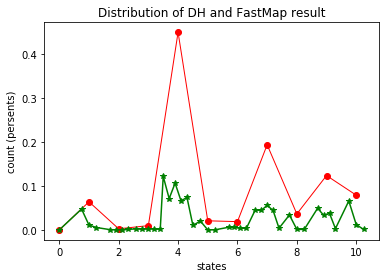

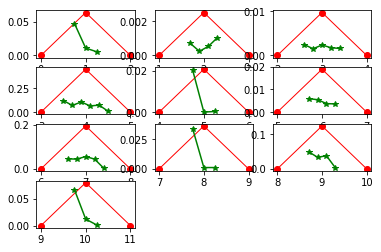

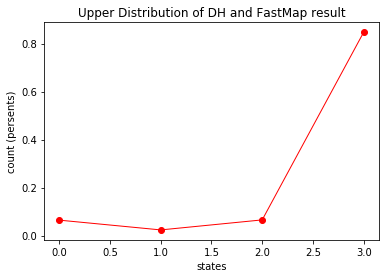

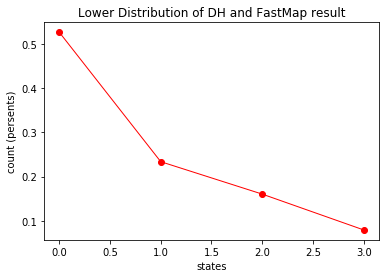

0.2311255844222816
#########Test for differential heuristic:upper
Pool size: 8
0.596993344385103
#########Test for differential heuristic:lower
Pool size: 8
0.2947269437636263
#########Test for differential heuristic:median
Pool size: 8
0.2444350718697069


In [26]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 21, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 18, epsilon, dis_store, alg)
S = int(1000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

### Some analysis

1. The improvements of precision is very tiny. (about 1%)
2. Upper tender to be higher than dismax (from abover image 3)
3. Lower tender to be lower than disaver (from abover image 4)

The inner situation of every states: analysis from abover image 1 and 2

Here the considerations are:

- The distribution of those states
- Inside every state, which point is clostest to the real distance?

Blew are the summary on random graph:

1. **10% upper < dismin**: Upper $$dis_{real} \to lower$$
2. 0.25% lower < dismin < upper < disaver: Dismin $$dis_{real} \to upper$$ 
3. 1% lower < dismin < disaver < upper < dismax:  Median $$dis_{real}$$ 
4. **46% lower < dismin < dismax < upper**: Disaver $$dis_{real}$$
5. 2.5% dismin < lower < upper < disaver: Lower $$dis_{real} \to lower$$
6. 2.5% dismin < lower < disaver < upper < dismax: Disaver $$dis_{real}$$
7. **16% dismin < lower < disaver < dismax < upper**: Dismax $$dis_{real} \to median$$
8. 4% disaver < lower < upper < dismax: Upper $$dis_{real} \to lower$$
9. **12% disaver < lower < dismax < upper**: Dismax $$dis_{real} \to lower$$
10. 8% dismax < lower: Lower $$dis_{real} \to lower$$

**Later plan**

Will state of $i \to j$ has any relation with state of $j \to i$, intuitivly there may have no relation, because the two way distance are not related. (Still need more consideration).

1. Try to analysis different graphs, especially the real map.
2. Then try to figure out the relationship between structure of network and the performance of FastMap.
3. Try to think about the idea of embedding general graph problem into the Euclidean space.

## Test the difference of edges

Density: 0.006935935935935936


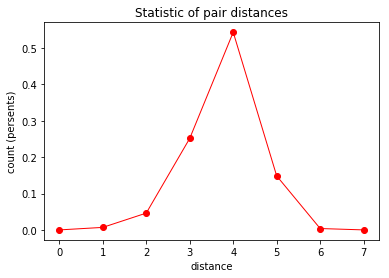

In [27]:
n = 1000
p = 0.007
low = 1
high = 1

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

dijkstra_path_length = get_dijkstra_path_length(G)

In [28]:
klist = [19, 20, 21, 22, 23, 24, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:19
Pool size: 8
(0.21271536073676175, 100886.0, 293020.0, 245294.0)
#########Test for K:20
Pool size: 8
(0.2055475383226527, 142364.0, 306716.0, 190120.0)
#########Test for K:21
Pool size: 8
(0.20586253336236582, 151978.0, 307620.0, 179602.0)
#########Test for K:22
Pool size: 8
(0.20750008853042956, 182898.0, 305506.0, 150796.0)
#########Test for K:23
Pool size: 8
(0.23427074893675423, 253872.0, 280884.0, 104444.0)
#########Test for K:24
Pool size: 8
(0.2169764209238177, 242050.0, 297298.0, 99852.0)
#########Test for K:25
Pool size: 8
(0.2260847298616443, 270684.0, 286308.0, 82208.0)


In [29]:
klist = [20, 30]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 20
#########Test for differential heuristic:upper
Pool size: 8
0.47672470020125807
#########Test for differential heuristic:lower
Pool size: 8
0.37093707763217854
#########Test for differential heuristic:median
Pool size: 8
0.2143753311385348
!!!!!!!!!The number of K: 30
#########Test for differential heuristic:upper
Pool size: 8
0.3996562085867151
#########Test for differential heuristic:lower
Pool size: 8
0.3225842839949001
#########Test for differential heuristic:median
Pool size: 8
0.1955428853782078


In [30]:
klist = [19, 20, 21, 22]
for K1 in klist:
    for K2 in klist:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:19, K2:19
Pool size: 8
0.4693415108725954
#########Test for K1:19, K2:20
Pool size: 8
0.4704341757459235
#########Test for K1:19, K2:21
Pool size: 8
0.5047735618264041
#########Test for K1:19, K2:22
Pool size: 8
0.4841151697118129
#########Test for K1:20, K2:19
Pool size: 8
0.4585536884534407
#########Test for K1:20, K2:20
Pool size: 8
0.4459841935837095
#########Test for K1:20, K2:21
Pool size: 8
0.45030987541900147
#########Test for K1:20, K2:22
Pool size: 8
0.47329990933942623
#########Test for K1:21, K2:19
Pool size: 8
0.4825521779556512
#########Test for K1:21, K2:20
Pool size: 8
0.47594478325443973
#########Test for K1:21, K2:21
Pool size: 8
0.45986808927756523
#########Test for K1:21, K2:22
Pool size: 8
0.46471942473957173
#########Test for K1:22, K2:19
Pool size: 8
0.514431669715715
#########Test for K1:22, K2:20
Pool size: 8
0.4624590977543981
#########Test for K1:22, K2:21
Pool size: 8
0.4739939617545649
#########Test for K1:22, K2:22
Pool size: 8
0.48499

Pool size: 8


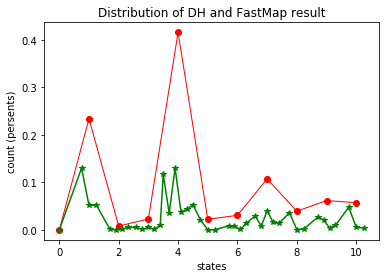

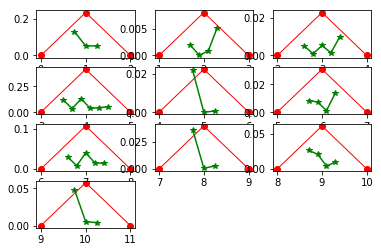

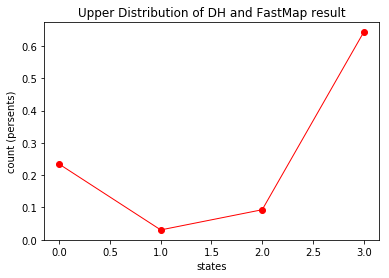

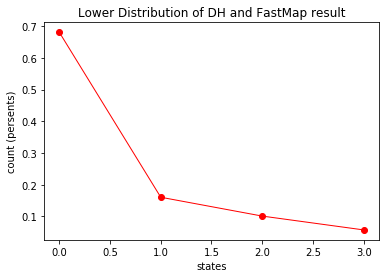

0.2245241079054399
#########Test for differential heuristic:upper
Pool size: 8
0.3861027154118089
#########Test for differential heuristic:lower
Pool size: 8
0.3030479195228909
#########Test for differential heuristic:median
Pool size: 8
0.18773718826520291


In [31]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 21, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 18, epsilon, dis_store, alg)
S = int(1000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

Density: 0.0071411411411411415


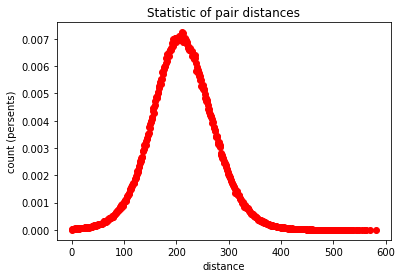

In [32]:
n = 1000
p = 0.007
low = 1
high = 200

G, density = utils.generate_random_digraph(n, p, low, high)
utils.distance_info(G)

dijkstra_path_length = get_dijkstra_path_length(G)

In [33]:
klist = [19, 20, 21, 22, 23, 24, 25]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:19
Pool size: 8
(0.2432887545588303, 137816.0, 4910.0, 496474.0)
#########Test for K:20
Pool size: 8
(0.22295081772328504, 180478.0, 5620.0, 453102.0)
#########Test for K:21
Pool size: 8
(0.2125224319183379, 213578.0, 5798.0, 419824.0)
#########Test for K:22
Pool size: 8
(0.20536496119288022, 238404.0, 5844.0, 394952.0)
#########Test for K:23
Pool size: 8
(0.19652747078982416, 264782.0, 6268.0, 368150.0)
#########Test for K:24
Pool size: 8
(0.19305095282718068, 291262.0, 6658.0, 341280.0)
#########Test for K:25
Pool size: 8
(0.19181161639074426, 316562.0, 6324.0, 316314.0)


In [34]:
klist = [26, 27, 28]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 0.5
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(800)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:26
Pool size: 8
(0.20629230535014614, 371330.0, 6034.0, 261836.0)
#########Test for K:27
Pool size: 8
(0.2188085140289049, 406784.0, 5736.0, 226680.0)
#########Test for K:28
Pool size: 8
(0.231351547264933, 445062.0, 5242.0, 188896.0)


Pool size: 8


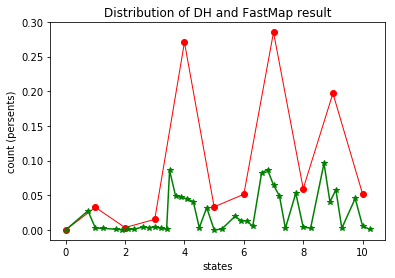

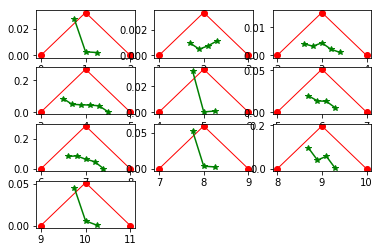

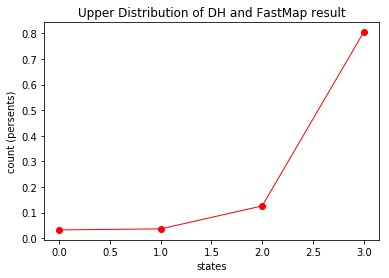

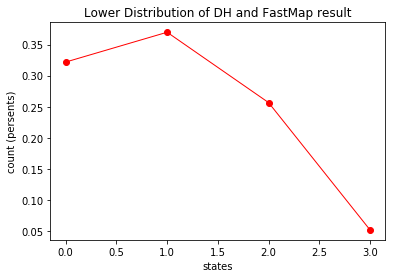

0.28042249781639433
#########Test for differential heuristic:upper
Pool size: 8
0.6662128363971501
#########Test for differential heuristic:lower
Pool size: 8
0.2752251941923079
#########Test for differential heuristic:median
Pool size: 8
0.27784644926327084


In [35]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 22, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 22, epsilon, dis_store, alg)
S = int(1000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

In [37]:
klist = [5, 10, 15, 20]
for K in klist:
    print("!!!!!!!!!The number of K: {}".format(K))
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 5
#########Test for differential heuristic:upper
Pool size: 8
1.1212199697447112
#########Test for differential heuristic:lower
Pool size: 8
0.5190312338902068
#########Test for differential heuristic:median
Pool size: 8
0.39379579175000057
!!!!!!!!!The number of K: 10
#########Test for differential heuristic:upper
Pool size: 8
0.9989193707573628
#########Test for differential heuristic:lower
Pool size: 8
0.42646475155501545
#########Test for differential heuristic:median
Pool size: 8
0.37051901809170673
!!!!!!!!!The number of K: 15
#########Test for differential heuristic:upper
Pool size: 8
0.8500698919590587
#########Test for differential heuristic:lower
Pool size: 8
0.372676216866148
#########Test for differential heuristic:median
Pool size: 8
0.32099090334378383
!!!!!!!!!The number of K: 20
#########Test for differential heuristic:upper
Pool size: 8
0.7932156892675493
#########Test for differential heuristic:lower
Pool size: 8
0.33772064445118555
#########

## With limit storage

This experiments test the improvement when only a little number of pivot distances are allowed to store, which can be very normal in real situations because sometime the dimension for Euclidean embedding is too big for storage to handle when it comes to true distances.

Pool size: 8


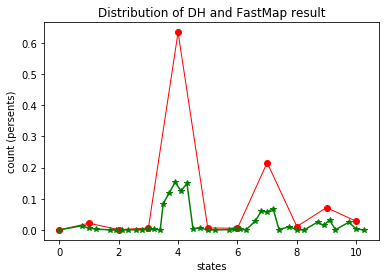

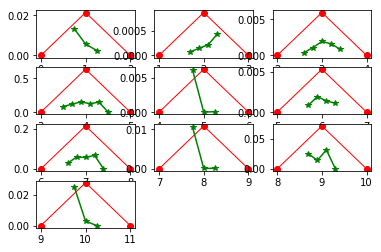

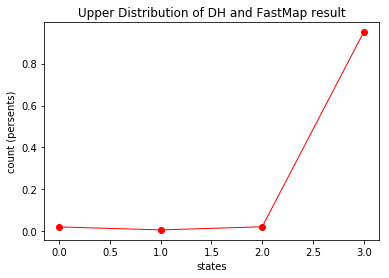

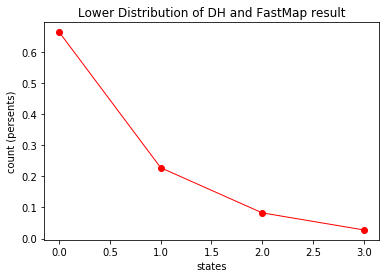

0.25170396980431853
#########Test for differential heuristic:upper
Pool size: 8
0.8615289450418123
#########Test for differential heuristic:lower
Pool size: 8
0.45432562053132264
#########Test for differential heuristic:median
Pool size: 8
0.3071807622040938


In [13]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
PNumber1 = 5
PNumber2 = 5
embedding_aver = difastmap_average_limitstorage(G, 21, epsilon, dis_store, PNumber1, alg)
embedding_max = difastmap_max_limitstorage(G, 18, epsilon, dis_store, PNumber2, alg)
S = int(1000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

**Summary:**

In this situation, the improvements is more clear, but maybe not fair.

We then need to figure out a way to regard the role of the stored true distances, maybe like a land